# <span style="color: orange"> Librerias </span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

2024-09-26 00:06:31.684395: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# <span style="color: orange"> Dataset </span>

In [2]:
def cargar_imagenes_desde_carpeta(base_path, categorias=['Fruits', 'Vegetables'], target_size=(64, 64)):
    imagenes = []
    etiquetas = []
    
    for categoria in categorias:
        categoria_path = os.path.join(base_path, categoria)
        
        for estado in ['Fresh', 'Rotten']:
            for fruta_veg in os.listdir(categoria_path):
                if fruta_veg.startswith(estado):
                    fruta_veg_path = os.path.join(categoria_path, fruta_veg)
                    
                    for archivo in os.listdir(fruta_veg_path):
                        if archivo.endswith(('.jpg', '.jpeg', '.png')):
                            img_path = os.path.join(fruta_veg_path, archivo)
                            try:
                                img = load_img(img_path, target_size=target_size)
                                img_array = img_to_array(img)
                                
                                imagenes.append(img_array)
                                
                                etiqueta = 1 if estado == 'Fresh' else 0
                                etiquetas.append(etiqueta)
                            except Exception as e:
                                print(f"Error al cargar {img_path}: {e}")
    
    return np.array(imagenes), np.array(etiquetas)

In [3]:
str_base_path = 'Fruits_Vegetables_Dataset(12000)'

In [4]:
imagenes, etiquetas = cargar_imagenes_desde_carpeta(str_base_path)

print(f'Número de imágenes cargadas: {len(imagenes)}')
print(f'Número de etiquetas cargadas: {len(etiquetas)}')

/Users/chrismerida/anaconda3/envs/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Número de imágenes cargadas: 11939
Número de etiquetas cargadas: 11939


# <span style="color: orange"> Data Augmentation </span>

In [5]:
# Aplicar Data Augmentation
train_data_generator = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    rotation_range=360,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    validation_split=0.2
)

In [6]:
# Generar lotes de imágenes con data augmentation
train_data_flow = train_data_generator.flow(
    imagenes, 
    etiquetas, 
    batch_size=32, 
    shuffle=True
)

# <span style="color: orange"> Split - Train & Test </span>

In [7]:
X_train, X_val, y_train, y_val = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=42, stratify=etiquetas)

In [8]:
print(f'Número de imágenes de entrenamiento: {len(X_train)}')
print(f'Número de imágenes de validación: {len(X_val)}')

Número de imágenes de entrenamiento: 9551
Número de imágenes de validación: 2388


In [9]:
train_data_generator = ImageDataGenerator(rescale=1/255.)
train_data_flow = train_data_generator.flow(
    X_train, 
    y_train, 
    batch_size=32, 
    shuffle=True
)

In [10]:
validation_data_generator = ImageDataGenerator(rescale=1/255.)
validation_data_flow = validation_data_generator.flow(
    X_val, 
    y_val, 
    batch_size=32,
    shuffle=False
)

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# <span style="color: orange"> CNN - Modelo 1 </span>

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

/Users/chrismerida/anaconda3/envs/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(train_data_flow, steps_per_epoch=len(train_data_flow), epochs=25, validation_data=validation_data_flow, validation_steps=len(validation_data_flow), verbose=1, callbacks=[early_stopping])

Epoch 1/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 9:27 2s/step - accuracy: 0.6875 - loss: 0.6878

/Users/chrismerida/anaconda3/envs/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


299/299 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.5884 - loss: 0.6618 - val_accuracy: 0.7940 - val_loss: 0.4589
Epoch 2/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 106us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 36s 123ms/step - accuracy: 0.7812 - loss: 0.4399

2024-09-26 00:07:57.517333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/chrismerida/anaconda3/envs/venv/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-09-26 00:07:57.529162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/chrismerida/anaconda3/envs/venv/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


299/299 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.7712 - loss: 0.4757 - val_accuracy: 0.8492 - val_loss: 0.3491
Epoch 4/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 57us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - accuracy: 0.9062 - loss: 0.3375

2024-09-26 00:08:24.518478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:08:24.524794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.8484 - loss: 0.3572 - val_accuracy: 0.8773 - val_loss: 0.3081
Epoch 6/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - accuracy: 0.8750 - loss: 0.2892

2024-09-26 00:08:51.575027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:08:51.582024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.8785 - loss: 0.2897 - val_accuracy: 0.8656 - val_loss: 0.3070
Epoch 8/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 64us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - accuracy: 0.8750 - loss: 0.3462

2024-09-26 00:09:18.538595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:09:18.545961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.8970 - loss: 0.2587 - val_accuracy: 0.9054 - val_loss: 0.2661
Epoch 10/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 63us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 36s 122ms/step - accuracy: 0.9688 - loss: 0.1055

2024-09-26 00:09:46.002859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:09:46.010887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.9153 - loss: 0.2086 - val_accuracy: 0.9171 - val_loss: 0.2225
Epoch 12/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 59us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 36s 123ms/step - accuracy: 0.9688 - loss: 0.1505

2024-09-26 00:10:13.636999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:10:13.643361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.9328 - loss: 0.1811 - val_accuracy: 0.9179 - val_loss: 0.2088
Epoch 14/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 15/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 38s 129ms/step - accuracy: 0.9062 - loss: 0.1663

2024-09-26 00:10:41.363477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:10:41.370330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.9244 - loss: 0.1834 - val_accuracy: 0.9112 - val_loss: 0.2398
Epoch 16/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 53us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 17/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 36s 123ms/step - accuracy: 0.9688 - loss: 0.1181

2024-09-26 00:11:09.052906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:11:09.058664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.9479 - loss: 0.1350 - val_accuracy: 0.9167 - val_loss: 0.2315
Epoch 18/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 63us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 19/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 37s 125ms/step - accuracy: 0.9062 - loss: 0.1285

2024-09-26 00:11:36.715119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:11:36.722295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.9491 - loss: 0.1264 - val_accuracy: 0.9175 - val_loss: 0.2609
Epoch 20/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 21/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - accuracy: 0.9688 - loss: 0.0505

2024-09-26 00:12:04.476939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:12:04.483769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.9522 - loss: 0.1172 - val_accuracy: 0.9238 - val_loss: 0.2264
Epoch 22/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 23/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 36s 122ms/step - accuracy: 0.9688 - loss: 0.1097

2024-09-26 00:12:32.206814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:12:32.212987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.9625 - loss: 0.1017 - val_accuracy: 0.9154 - val_loss: 0.2832


In [15]:
test_loss, test_accuracy = model.evaluate(validation_data_flow, verbose=1)
print(f"Precisión en datos de prueba: {test_accuracy * 100:.2f}%")

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9170 - loss: 0.2085
Precisión en datos de prueba: 91.79%


# <span style="color: orange"> CNN - Modelo 2 </span>

In [16]:
model_2 = Sequential()

model_2.add(Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model_2.add(AveragePooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (5, 5), activation='relu'))
model_2.add(AveragePooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(128, (5, 5), activation='relu'))
model_2.add(AveragePooling2D(pool_size=(2, 2))) 

model_2.add(Flatten())

model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5)) 
model_2.add(Dense(64, activation='relu'))

model_2.add(Dense(1, activation='sigmoid'))

In [17]:
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
history_2 = model_2.fit(train_data_flow, steps_per_epoch=len(train_data_flow), epochs=25, validation_data=validation_data_flow, validation_steps=len(validation_data_flow), 
    verbose=1, callbacks=[early_stopping])

Epoch 1/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - accuracy: 0.5319 - loss: 0.6898 - val_accuracy: 0.6147 - val_loss: 0.6370
Epoch 2/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 97us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 42s 142ms/step - accuracy: 0.4375 - loss: 0.6994

2024-09-26 00:13:39.306586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:13:39.316932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - accuracy: 0.6373 - loss: 0.6290 - val_accuracy: 0.7198 - val_loss: 0.5553
Epoch 4/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 58us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 42s 143ms/step - accuracy: 0.7500 - loss: 0.5304

2024-09-26 00:14:14.167021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:14:14.173178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.7088 - loss: 0.5671 - val_accuracy: 0.7446 - val_loss: 0.5166
Epoch 6/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 42s 142ms/step - accuracy: 0.8750 - loss: 0.4674

2024-09-26 00:14:49.065036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:14:49.071511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.7515 - loss: 0.5075 - val_accuracy: 0.7328 - val_loss: 0.5235
Epoch 8/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 65us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 44s 149ms/step - accuracy: 0.5938 - loss: 0.5933

2024-09-26 00:15:24.207169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:15:24.214705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.7530 - loss: 0.4863 - val_accuracy: 0.7094 - val_loss: 0.5584


In [19]:
test_loss_2, test_accuracy_2 = model_2.evaluate(validation_data_flow, verbose=1)
print(f"Precisión en datos de prueba: {test_accuracy_2 * 100:.2f}%")

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6162 - loss: 0.6379
Precisión en datos de prueba: 61.47%


# <span style="color: orange"> CNN - Modelo 3 </span>

In [20]:
model_3 = Sequential()

model_3.add(Conv2D(32, (7, 7), activation='relu', input_shape=(64, 64, 3)))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(64, (7, 7), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2))) 

model_3.add(Conv2D(128, (7, 7), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Flatten())

model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5)) 
model_3.add(Dense(128, activation='relu'))

model_3.add(Dense(1, activation='sigmoid'))

In [21]:
model_3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
history_3 = model_3.fit(train_data_flow, steps_per_epoch=len(train_data_flow), epochs=25, validation_data=validation_data_flow, validation_steps=len(validation_data_flow), 
    verbose=1, callbacks=[early_stopping])

Epoch 1/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - accuracy: 0.5153 - loss: 0.6969 - val_accuracy: 0.5331 - val_loss: 0.6833
Epoch 2/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 102us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 51s 172ms/step - accuracy: 0.5625 - loss: 0.6824

2024-09-26 00:16:45.128646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:16:45.136510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.5551 - loss: 0.6807 - val_accuracy: 0.6533 - val_loss: 0.6136
Epoch 4/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 59us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 46s 155ms/step - accuracy: 0.7500 - loss: 0.5844

2024-09-26 00:17:25.034198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:17:25.041004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 39s 131ms/step - accuracy: 0.6314 - loss: 0.6317 - val_accuracy: 0.6616 - val_loss: 0.5946
Epoch 6/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 58us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/25
  1/299 ━━━━━━━━━━━━━━━━━━━━ 44s 150ms/step - accuracy: 0.8750 - loss: 0.4417

2024-09-26 00:18:04.125106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:18:04.131467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - accuracy: 0.6361 - loss: 0.6151 - val_accuracy: 0.7257 - val_loss: 0.5463
Epoch 8/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/25


2024-09-26 00:18:44.282051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-26 00:18:44.288614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


299/299 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - accuracy: 0.7100 - loss: 0.5477 - val_accuracy: 0.7475 - val_loss: 0.5141


In [23]:
test_loss_3, test_accuracy_3 = model_3.evaluate(validation_data_flow, verbose=1)
print(f"Precisión en datos de prueba: {test_accuracy_2 * 100:.2f}%")

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5367 - loss: 0.6833
Precisión en datos de prueba: 61.47%


# <span style="color: orange"> Gráficas Rendimiento </span>

### Modelo 1

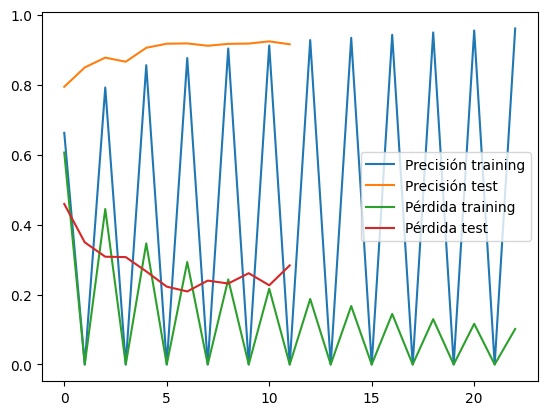

In [24]:
plt.plot(history.history['accuracy'], label='Precisión training')
plt.plot(history.history['val_accuracy'], label='Precisión test')
plt.plot(history.history['loss'], label='Pérdida training')
plt.plot(history.history['val_loss'], label='Pérdida test')
plt.legend()
plt.show()

### Modelo 2

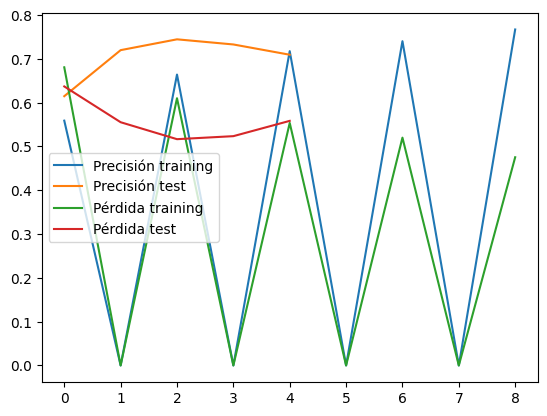

In [25]:
plt.plot(history_2.history['accuracy'], label='Precisión training')
plt.plot(history_2.history['val_accuracy'], label='Precisión test')
plt.plot(history_2.history['loss'], label='Pérdida training')
plt.plot(history_2.history['val_loss'], label='Pérdida test')
plt.legend()
plt.show()

### Modelo 3

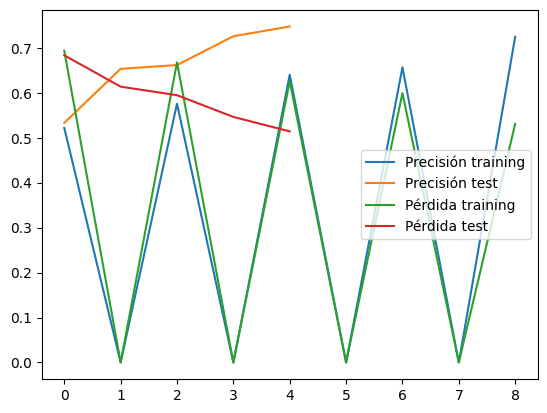

In [26]:
plt.plot(history_3.history['accuracy'], label='Precisión training')
plt.plot(history_3.history['val_accuracy'], label='Precisión test')
plt.plot(history_3.history['loss'], label='Pérdida training')
plt.plot(history_3.history['val_loss'], label='Pérdida test')
plt.legend()
plt.show()

# <span style="color: orange"> Guardar Modelos </span>

In [27]:
model.save('modelo_1.keras')
model_2.save('modelo_2.keras')
model_3.save('modelo_3.keras')

# <span style="color: orange"> Pregunta </span>

### ¿Por qué cree que la CNN que seleccionó funciona mejor que otras?
El modelo es capaz de captar características y aprender patrones complejos, lo cual permite para hacer mejores predicciones. Las técnicas usadas permiten darle más variedad al conjunto de training, lo que ayuda al modelo a adaptarse a diferentes situaciones y generalizar sus predicciones. Implementar funciones y optimizadores permite desconectar unas neuronas durante el training, de esta forma evitar el sobreajuste, haciendo al modelo mas preciso en las predicciones. 